## Replicating the Wind Direction Forecast Algorithm
From Howland et al.: Closed-loop wake steering: Diurnal cycle ABL

#### Linear Ridge / Lasso Regression approach

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

First process the data into its training, testing and validation sets

![data process](alg-data-processing.png)

In [6]:
# parse data set into t_1 (past), t_2 (present), t_3 (future)
meters = 40 # deinfe where to use wind dir measurements from either 40, 100 m above ground
T = 15 * 60 # 15 minutes in seconds

In [7]:
def parse_data(data_df, T, x_features=["t"]):
    parse_model_data = pd.DataFrame()

    for x_ft in x_features:
        # past time and wind direction goes from t_initial -> t_final - 2T
        parse_model_data[f"{x_ft}1"] = data_df[x_ft][:-2*T]
        parse_model_data["e_t1"] = data_df[f"wind direction at {meters}m (deg)"][:-2*T]
        parse_model_data["e_t1_sin"] = np.sin(np.deg2rad(data_df[f"wind direction at {meters}m (deg)"][:-2*T]))
        parse_model_data["e_t1_cos"] = np.cos(np.deg2rad(data_df[f"wind direction at {meters}m (deg)"][:-2*T]))


        # present time and wind direction goes from t_initial + T -> t_final - T
        parse_model_data[f"{x_ft}2"] = data_df[x_ft][T:-T]
        parse_model_data["e_t2"] = data_df[f"wind direction at {meters}m (deg)"][T:-T]
        parse_model_data["e_t2_sin"] = np.sin(np.deg2rad(data_df[f"wind direction at {meters}m (deg)"][T:-T]))
        parse_model_data["e_t2_cos"] = np.cos(np.deg2rad(data_df[f"wind direction at {meters}m (deg)"][T:-T]))

        # future time and wind direction goes from t_0 + 2T -> t_final
        parse_model_data[f"{x_ft}3"] = data_df[x_ft][2*T:]
        parse_model_data["e_t3"] = data_df[f"wind direction at {meters}m (deg)"][2*T:]
        parse_model_data["e_t3_sin"] = np.sin(np.deg2rad(data_df[f"wind direction at {meters}m (deg)"][2*T:]))
        parse_model_data["e_t3_cos"] = np.cos(np.deg2rad(data_df[f"wind direction at {meters}m (deg)"][2*T:]))

    return parse_model_data

In [8]:
all_india_data_df = pd.read_csv("data/NREL data/all_NREL_india_wind_data_2014.csv")
x_features = ["t", "temperature at 120m (C)", "air pressure at 40m (Pa)", "wind speed at 80m (m/s)"]
parsed_model_data = parse_data(all_india_data_df, T, x_features)
parsed_model_data

,t1,e_t1,e_t1_sin,e_t1_cos,t2,e_t2,e_t2_sin,e_t2_cos,t3,e_t3,...,e_t3_cos,temperature at 120m (C)1,temperature at 120m (C)2,temperature at 120m (C)3,air pressure at 40m (Pa)1,air pressure at 40m (Pa)2,air pressure at 40m (Pa)3,wind speed at 80m (m/s)1,wind speed at 80m (m/s)2,wind speed at 80m (m/s)3
0,1388534400000000000,61.15,0.875886,0.482518,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,12.23,NaN,NaN,97370,NaN,NaN,3.76,NaN,NaN
1,1388535300000000000,56.90,0.837719,0.546102,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,12.13,NaN,NaN,97370,NaN,NaN,3.77,NaN,NaN
2,1388536200000000000,54.70,0.816138,0.577858,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,12.02,NaN,NaN,97370,NaN,NaN,3.77,NaN,NaN
3,1388537100000000000,51.25,0.779884,0.625923,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,11.90,NaN,NaN,97380,NaN,NaN,3.74,NaN,NaN
4,1388538000000000000,48.28,0.746406,0.665491,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,11.76,NaN,NaN,97390,NaN,NaN,3.73,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33235,1418445900000000000,230.09,-0.767053,-0.641584,1.418446e+18,230.09,-0.767053,-0.641584,1.418446e+18,230.09,...,-0.641584,21.29,21.29,21.29,96880,96880.0,96880.0,2.50,2.50,2.50
33236,1418446800000000000,233.17,-0.800418,-0.599443,1.418447e+18,233.17,-0.800418,-0.599443,1.418447e+18,233.17,...,-0.599443,21.93,21.93,21.93,96880,96880.0,96880.0,2.82,2.82,2.82
33237,1418447700000000000,231.69,-0.784668,-0.619916,1.418448e+18,231.69,-0.784668,-0.619916,1.418448e+18,231.69,...,-0.619916,22.38,22.38,22.38,96880,96880.0,96880.0,3.03,3.03,3.03
33238,1418448600000000000,227.42,-0.736333,-0.676619,1.418449e+18,227.42,-0.736333,-0.676619,1.418449e+18,227.42,...,-0.676619,22.62,22.62,22.62,96880,96880.0,96880.0,3.24,3.24,3.24


In [9]:
# parsing x, y train, test and validation sets
x_features_123 = [ft+str(i) for i in range(1,4) for ft in x_features]
# get x training and testing data corresponding to x_feature column
X_train, X_test, X_val = parsed_model_data[x_features_123].dropna().to_numpy(), parsed_model_data[x_features_123].dropna().to_numpy(), parsed_model_data[x_features_123].dropna().to_numpy()
X_train, X_test, X_val

(array([[1.3901544e+18, 1.5260000e+01, 9.7480000e+04, ..., 1.5260000e+01,
         9.7480000e+04, 3.2200000e+00],
        [1.3901553e+18, 1.5290000e+01, 9.7480000e+04, ..., 1.5290000e+01,
         9.7480000e+04, 3.2700000e+00],
        [1.3901562e+18, 1.5290000e+01, 9.7480000e+04, ..., 1.5290000e+01,
         9.7480000e+04, 3.2400000e+00],
        ...,
        [1.4184477e+18, 2.2380000e+01, 9.6880000e+04, ..., 2.2380000e+01,
         9.6880000e+04, 3.0300000e+00],
        [1.4184486e+18, 2.2620000e+01, 9.6880000e+04, ..., 2.2620000e+01,
         9.6880000e+04, 3.2400000e+00],
        [1.4184495e+18, 2.2730000e+01, 9.6880000e+04, ..., 2.2730000e+01,
         9.6880000e+04, 3.4100000e+00]]),
 array([[1.3901544e+18, 1.5260000e+01, 9.7480000e+04, ..., 1.5260000e+01,
         9.7480000e+04, 3.2200000e+00],
        [1.3901553e+18, 1.5290000e+01, 9.7480000e+04, ..., 1.5290000e+01,
         9.7480000e+04, 3.2700000e+00],
        [1.3901562e+18, 1.5290000e+01, 9.7480000e+04, ..., 1.5290000e+01,

In [10]:
# get x training and testing data corresponding to x_feature column
y_train, y_test, y_val = parsed_model_data[["e_t1"]].dropna().to_numpy(), parsed_model_data[["e_t2"]].dropna().to_numpy(), parsed_model_data[["e_t3"]].dropna().to_numpy()
y_train, y_test, y_val

(array([[ 61.15],
        [ 56.9 ],
        [ 54.7 ],
        ...,
        [231.69],
        [227.42],
        [225.4 ]]),
 array([[101.1 ],
        [105.57],
        [117.8 ],
        ...,
        [231.69],
        [227.42],
        [225.4 ]]),
 array([[ 81.33],
        [ 83.09],
        [ 86.59],
        ...,
        [231.69],
        [227.42],
        [225.4 ]]))

In [42]:
from sklearn.linear_model import Ridge, Lasso

def regression_direction_estimation(data_df, model_type, x_feature="t"):
    '''
    x_feature : str : column name to use as model inputs {}
    model_type : str : {'Lasso', 'Ridge'}
    '''
    # get x training and testing data corresponding to x_feature column
    X_train, X_val = data_df[["e_t1_cos", "e_t1_sin"]].dropna().to_numpy(), data_df[["e_t2_cos", "e_t2_sin"]].dropna().to_numpy()
    if x_feature:
        X_train, X_val = data_df[[x_feature+"1", "e_t1_cos", "e_t1_sin"]].dropna().to_numpy(), data_df[[x_feature+"2", "e_t2_cos", "e_t2_sin"]].dropna().to_numpy()

    # get x training and testing data corresponding to x_feature column
    y_train, y_val = data_df[["e_t2_cos", "e_t2_sin"]].dropna().to_numpy(), data_df[["e_t3_cos", "e_t3_sin"]].dropna().to_numpy()

    # standardize training and testing data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.fit_transform(X_val)
    # y_train = scaler.fit_transform(y_train)
    # y_val = scaler.fit_transform(y_val)

    train_mse = list()
    val_mse = list()
    coeffs = list()

    # initialize set of lambdas to conduct grid search over
    lambdas = np.logspace(-4,9,100)
    print(X_train.shape)
    min_shape = min(X_train.shape[0], X_val.shape[0], y_train.shape[0], y_val.shape[0])
    for lam in lambdas:
        ## Lasso Regression
        if model_type == "Lasso":
            # train lasso model
            model = Lasso(alpha=lam).fit(X_train[:min_shape], y_train[:min_shape])
        
        ## Ridge Regression
        elif model_type == "Ridge":
            model = Ridge(alpha=lam).fit(X_train[:min_shape], y_train[:min_shape])
        
        # compute lasso train and test errors
        # print(X_train[:min_shape])
        # print(X_train[:,0][:min_shape])
        # y_train_pred_cos = model.predict(X_train[:min_shape])
        print("True", y_train[:min_shape,0])
        
        y_train_pred_cos = np.rad2deg(np.arccos(model.predict(X_train[:min_shape])))
        y_train_pred = model.predict(X_train[:min_shape])
        print("Pred angles: ", y_train_pred_cos[:,0])
        train_mse.append(np.mean((y_train[:min_shape] -  y_train_pred)**2))

        y_val_pred_cos = np.rad2deg(np.arccos(model.predict(X_val[:min_shape])))
        y_val_pred = model.predict(X_val[:min_shape])
        val_mse.append(np.mean((y_val[:min_shape] - y_val_pred)**2))
        coeffs.append(model.coef_[0])
        
    return lambdas, train_mse, val_mse, coeffs

In [43]:
def plot_mse_coeff(data_df, model_type, x_features=["t"]):

    # create regression and plot MSEs
    lambdas, train_mse, test_mse, coeffs = regression_direction_estimation(data_df, model_type)
    df = pd.DataFrame({"lambdas": lambdas, "train_MSE": train_mse, "test_MSE": test_mse, "coeffs": coeffs})
    plt.plot(lambdas, train_mse, label="Train MSE",)
    plt.plot(lambdas, test_mse, label="Test MSE", linestyle='--')

    # create MSE plot axes and labels
    plt.title(model_type + " Regression Lambda Grid Search: MSE")
    plt.xscale('log')
    plt.xlabel("lambda")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()

    # plot labeled coefficients
    plt.plot(lambdas, coeffs, label="Coef.",)
    
    # create plot axes
    plt.title(model_type + " Regression Lambda Grid Search: Coefficients")
    plt.xscale('log')
    plt.xlabel('lambda')
    plt.ylabel('coefficients')
    plt.legend()
    plt.show()
    return df


In [44]:
def plot_mse_coeffs(data_df, model_type, x_features=["t"]):
    # color code each feature x feature regression
    colors = ['red', 'blue', 'orange', 'green', 'grey']
    # store all models' MSEs and coefficients to plot later
    all_train_mses = []
    all_test_mses = []
    all_coeffs = []
    
    # create figure to plot it
    fig = plt.figure()
    ax = plt.subplot(111)
    # create regression for each feature and plot MSEs
    for i in range(len(x_features)):
        col =  x_features[i]
        print(f"Modeling {col}")
        # get regression results for model trained on feature col
        lambdas, train_mse, test_mse, coeffs = regression_direction_estimation(data_df, model_type, x_feature=col)
        # plot
        color = colors[i]
        ax.plot(lambdas, train_mse, label= col +" Train MSE", color=color)
        ax.plot(lambdas, test_mse, label= col + " Test MSE", color=color, linestyle='--')

        all_train_mses.append(train_mse)
        all_test_mses.append(test_mse)
        all_coeffs.append(coeffs)

    # create MSE plot axes and labels
    ax.set_title(model_type + " Regression Lambda Grid Search: MSE")
    ax.set_xscale('log')
    ax.set_xlabel("lambda")
    ax.set_ylabel("MSE")
    # shrink axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0,box.y0,box.width*0.8,box.height])
    
    # moving legend outside of plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    # create figure to plot coefficients in
    fig = plt.figure()
    ax = plt.subplot(111)
    # plot labeled coefficients
    for i in range(len(x_features)):
        col =  x_features[i]
        color = colors[i]
        ax.plot(lambdas, all_coeffs[i], label=col + " Coef.", color=color)

    
    # create plot axes
    ax.set_title(model_type + " Regression Lambda Grid Search: Coefficients")
    ax.set_xscale('log')
    ax.set_xlabel('lambda')
    ax.set_ylabel('coefficients')
    # shrink axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0,box.y0,box.width*0.8,box.height])
    
    # moving legend outside of plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    return {'lambdas': lambdas, 
            'all_train_mses': all_train_mses, 
            'all_test_mses': all_test_mses, 
            'all_coeffs': all_coeffs}


In [45]:
regression_direction_estimation(parsed_model_data, model_type="Ridge")

(33240, 3)
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [85.61056054 85.63103102 85.64132325 ... 95.16450711 95.09160285
 95.04205292]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [85.61056054 85.63103103 85.64132325 ... 95.1645071  95.09160284
 95.04205292]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [85.61056055 85.63103103 85.64132326 ... 95.16450709 95.09160283
 95.0420529 ]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [85.61056055 85.63103104 85.64132327 ... 95.16450708 95.09160282
 95.04205289]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [85.61056057 85.63103105 85.64132328 ... 95.16450705 95.09160279
 95.04205287]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [85.61

(array([1.00000000e-04, 1.35304777e-04, 1.83073828e-04, 2.47707636e-04,
        3.35160265e-04, 4.53487851e-04, 6.13590727e-04, 8.30217568e-04,
        1.12332403e-03, 1.51991108e-03, 2.05651231e-03, 2.78255940e-03,
        3.76493581e-03, 5.09413801e-03, 6.89261210e-03, 9.32603347e-03,
        1.26185688e-02, 1.70735265e-02, 2.31012970e-02, 3.12571585e-02,
        4.22924287e-02, 5.72236766e-02, 7.74263683e-02, 1.04761575e-01,
        1.41747416e-01, 1.91791026e-01, 2.59502421e-01, 3.51119173e-01,
        4.75081016e-01, 6.42807312e-01, 8.69749003e-01, 1.17681195e+00,
        1.59228279e+00, 2.15443469e+00, 2.91505306e+00, 3.94420606e+00,
        5.33669923e+00, 7.22080902e+00, 9.77009957e+00, 1.32194115e+01,
        1.78864953e+01, 2.42012826e+01, 3.27454916e+01, 4.43062146e+01,
        5.99484250e+01, 8.11130831e+01, 1.09749877e+02, 1.48496826e+02,
        2.00923300e+02, 2.71858824e+02, 3.67837977e+02, 4.97702356e+02,
        6.73415066e+02, 9.11162756e+02, 1.23284674e+03, 1.668100

(33240, 3)
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [85.61056054 85.63103102 85.64132325 ... 95.16450711 95.09160285
 95.04205292]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [85.61056054 85.63103103 85.64132325 ... 95.1645071  95.09160284
 95.04205292]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [85.61056055 85.63103103 85.64132326 ... 95.16450709 95.09160283
 95.0420529 ]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [85.61056055 85.63103104 85.64132327 ... 95.16450708 95.09160282
 95.04205289]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [85.61056057 85.63103105 85.64132328 ... 95.16450705 95.09160279
 95.04205287]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [85.61

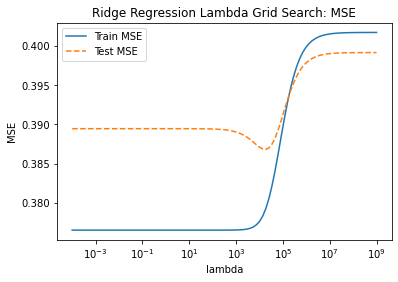

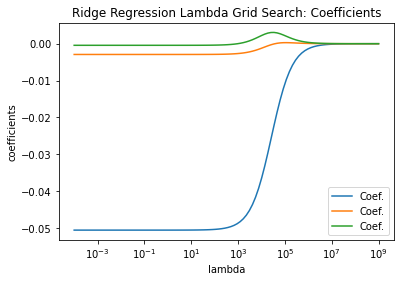

,lambdas,train_MSE,test_MSE,coeffs
0,1.000000e-04,0.376514,0.389435,"[-0.0505327879464271, -0.002919213960501174, -..."
1,1.353048e-04,0.376514,0.389435,"[-0.050532787877156524, -0.0029192139511356988..."
2,1.830738e-04,0.376514,0.389435,"[-0.05053278778343014, -0.0029192139384637663,..."
3,2.477076e-04,0.376514,0.389435,"[-0.05053278765661387, -0.002919213921318034, ..."
4,3.351603e-04,0.376514,0.389435,"[-0.0505327874850254, -0.0029192138981190404, ..."
...,...,...,...,...
95,2.983647e+08,0.401690,0.399127,"[-4.718673966423767e-06, 2.6601958023050134e-0..."
96,4.037017e+08,0.401692,0.399129,"[-3.4875333520564737e-06, 1.9662557318012724e-..."
97,5.462277e+08,0.401693,0.399129,"[-2.5775895347698124e-06, 1.453302716689352e-0..."
98,7.390722e+08,0.401694,0.399130,"[-1.9050524038350277e-06, 1.0741490439012348e-..."


In [46]:
df = plot_mse_coeff(parsed_model_data, model_type="Ridge")
df

In [47]:
parsed_model_data

,t1,e_t1,e_t1_sin,e_t1_cos,t2,e_t2,e_t2_sin,e_t2_cos,t3,e_t3,...,e_t3_cos,temperature at 120m (C)1,temperature at 120m (C)2,temperature at 120m (C)3,air pressure at 40m (Pa)1,air pressure at 40m (Pa)2,air pressure at 40m (Pa)3,wind speed at 80m (m/s)1,wind speed at 80m (m/s)2,wind speed at 80m (m/s)3
0,1388534400000000000,61.15,0.875886,0.482518,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,12.23,NaN,NaN,97370,NaN,NaN,3.76,NaN,NaN
1,1388535300000000000,56.90,0.837719,0.546102,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,12.13,NaN,NaN,97370,NaN,NaN,3.77,NaN,NaN
2,1388536200000000000,54.70,0.816138,0.577858,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,12.02,NaN,NaN,97370,NaN,NaN,3.77,NaN,NaN
3,1388537100000000000,51.25,0.779884,0.625923,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,11.90,NaN,NaN,97380,NaN,NaN,3.74,NaN,NaN
4,1388538000000000000,48.28,0.746406,0.665491,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,11.76,NaN,NaN,97390,NaN,NaN,3.73,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33235,1418445900000000000,230.09,-0.767053,-0.641584,1.418446e+18,230.09,-0.767053,-0.641584,1.418446e+18,230.09,...,-0.641584,21.29,21.29,21.29,96880,96880.0,96880.0,2.50,2.50,2.50
33236,1418446800000000000,233.17,-0.800418,-0.599443,1.418447e+18,233.17,-0.800418,-0.599443,1.418447e+18,233.17,...,-0.599443,21.93,21.93,21.93,96880,96880.0,96880.0,2.82,2.82,2.82
33237,1418447700000000000,231.69,-0.784668,-0.619916,1.418448e+18,231.69,-0.784668,-0.619916,1.418448e+18,231.69,...,-0.619916,22.38,22.38,22.38,96880,96880.0,96880.0,3.03,3.03,3.03
33238,1418448600000000000,227.42,-0.736333,-0.676619,1.418449e+18,227.42,-0.736333,-0.676619,1.418449e+18,227.42,...,-0.676619,22.62,22.62,22.62,96880,96880.0,96880.0,3.24,3.24,3.24


Modeling t
(33240, 3)
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [85.61056054 85.63103102 85.64132325 ... 95.16450711 95.09160285
 95.04205292]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [85.61056054 85.63103103 85.64132325 ... 95.1645071  95.09160284
 95.04205292]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [85.61056055 85.63103103 85.64132326 ... 95.16450709 95.09160283
 95.0420529 ]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [85.61056055 85.63103104 85.64132327 ... 95.16450708 95.09160282
 95.04205289]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [85.61056057 85.63103105 85.64132328 ... 95.16450705 95.09160279
 95.04205287]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angl

<ipython-input-42-aa9e171af751>:47: RuntimeWarning: invalid value encountered in arccos
  y_train_pred_cos = np.rad2deg(np.arccos(model.predict(X_train[:min_shape])))
<ipython-input-42-aa9e171af751>:52: RuntimeWarning: invalid value encountered in arccos
  y_val_pred_cos = np.rad2deg(np.arccos(model.predict(X_val[:min_shape])))
<ipython-input-42-aa9e171af751>:47: RuntimeWarning: invalid value encountered in arccos
  y_train_pred_cos = np.rad2deg(np.arccos(model.predict(X_train[:min_shape])))
<ipython-input-42-aa9e171af751>:52: RuntimeWarning: invalid value encountered in arccos
  y_val_pred_cos = np.rad2deg(np.arccos(model.predict(X_val[:min_shape])))
<ipython-input-42-aa9e171af751>:47: RuntimeWarning: invalid value encountered in arccos
  y_train_pred_cos = np.rad2deg(np.arccos(model.predict(X_train[:min_shape])))
<ipython-input-42-aa9e171af751>:52: RuntimeWarning: invalid value encountered in arccos
  y_val_pred_cos = np.rad2deg(np.arccos(model.predict(X_val[:min_shape])))
<ipython-i

True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [82.55912262 82.44006754 82.34467974 ... 90.7637364  90.87622214
 90.83265442]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [82.55912712 82.44007219 82.3446845  ... 90.76373475 90.87622015
 90.83265235]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [82.55913319 82.44007848 82.34469094 ... 90.7637325  90.87621745
 90.83264955]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [82.55914142 82.44008699 82.34469965 ... 90.76372947 90.8762138
 90.83264575]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [82.55915255 82.4400985  82.34471143 ... 90.76372536 90.87620887
 90.83264063]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [82.5591676  82.44

<ipython-input-42-aa9e171af751>:47: RuntimeWarning: invalid value encountered in arccos
  y_train_pred_cos = np.rad2deg(np.arccos(model.predict(X_train[:min_shape])))
<ipython-input-42-aa9e171af751>:52: RuntimeWarning: invalid value encountered in arccos
  y_val_pred_cos = np.rad2deg(np.arccos(model.predict(X_val[:min_shape])))
<ipython-input-42-aa9e171af751>:47: RuntimeWarning: invalid value encountered in arccos
  y_train_pred_cos = np.rad2deg(np.arccos(model.predict(X_train[:min_shape])))
<ipython-input-42-aa9e171af751>:52: RuntimeWarning: invalid value encountered in arccos
  y_val_pred_cos = np.rad2deg(np.arccos(model.predict(X_val[:min_shape])))
<ipython-input-42-aa9e171af751>:47: RuntimeWarning: invalid value encountered in arccos
  y_train_pred_cos = np.rad2deg(np.arccos(model.predict(X_train[:min_shape])))
<ipython-input-42-aa9e171af751>:52: RuntimeWarning: invalid value encountered in arccos
  y_val_pred_cos = np.rad2deg(np.arccos(model.predict(X_val[:min_shape])))
<ipython-i

Pred angles:  [85.17133091 85.12077607 85.07523592 ... 90.1146608  90.10302489
 90.04202602]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [85.69666202 85.65533184 85.61702498 ... 90.05183226 90.0294095
 89.97048085]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [86.24955347 86.21664459 86.18515381 ... 90.00637159 89.97659235
 89.9213547 ]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [86.807787   86.78218955 86.75684035 ... 89.98024354 89.94672572
 89.89658393]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [87.34809073 87.32856116 87.30852644 ... 89.97228467 89.93826282
 89.89418474]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [87.84980845 87.83512638 87.81953291 ... 89.97888271 89.94681438
 89.90922691]
True [-0.19252197 -0.26

<ipython-input-42-aa9e171af751>:47: RuntimeWarning: invalid value encountered in arccos
  y_train_pred_cos = np.rad2deg(np.arccos(model.predict(X_train[:min_shape])))
<ipython-input-42-aa9e171af751>:52: RuntimeWarning: invalid value encountered in arccos
  y_val_pred_cos = np.rad2deg(np.arccos(model.predict(X_val[:min_shape])))
<ipython-input-42-aa9e171af751>:47: RuntimeWarning: invalid value encountered in arccos
  y_train_pred_cos = np.rad2deg(np.arccos(model.predict(X_train[:min_shape])))
<ipython-input-42-aa9e171af751>:52: RuntimeWarning: invalid value encountered in arccos
  y_val_pred_cos = np.rad2deg(np.arccos(model.predict(X_val[:min_shape])))
<ipython-input-42-aa9e171af751>:47: RuntimeWarning: invalid value encountered in arccos
  y_train_pred_cos = np.rad2deg(np.arccos(model.predict(X_train[:min_shape])))
<ipython-input-42-aa9e171af751>:52: RuntimeWarning: invalid value encountered in arccos
  y_val_pred_cos = np.rad2deg(np.arccos(model.predict(X_val[:min_shape])))
<ipython-i

Pred angles:  [84.30824649 84.26863009 84.2410239  ... 88.74796344 88.83655601
 88.82841893]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [84.3082465  84.26863011 84.24102391 ... 88.74796342 88.83655599
 88.82841891]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [84.30824652 84.26863012 84.24102393 ... 88.7479634  88.83655597
 88.82841889]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [84.30824654 84.26863015 84.24102395 ... 88.74796338 88.83655594
 88.82841886]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [84.30824657 84.26863018 84.24102399 ... 88.74796334 88.8365559
 88.82841882]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [84.30824662 84.26863023 84.24102403 ... 88.7479633  88.83655584
 88.82841876]
True [-0.19252197 -0.26

<ipython-input-42-aa9e171af751>:52: RuntimeWarning: invalid value encountered in arccos
  y_val_pred_cos = np.rad2deg(np.arccos(model.predict(X_val[:min_shape])))
<ipython-input-42-aa9e171af751>:47: RuntimeWarning: invalid value encountered in arccos
  y_train_pred_cos = np.rad2deg(np.arccos(model.predict(X_train[:min_shape])))
<ipython-input-42-aa9e171af751>:52: RuntimeWarning: invalid value encountered in arccos
  y_val_pred_cos = np.rad2deg(np.arccos(model.predict(X_val[:min_shape])))
<ipython-input-42-aa9e171af751>:47: RuntimeWarning: invalid value encountered in arccos
  y_train_pred_cos = np.rad2deg(np.arccos(model.predict(X_train[:min_shape])))
<ipython-input-42-aa9e171af751>:52: RuntimeWarning: invalid value encountered in arccos
  y_val_pred_cos = np.rad2deg(np.arccos(model.predict(X_val[:min_shape])))
<ipython-input-42-aa9e171af751>:47: RuntimeWarning: invalid value encountered in arccos
  y_train_pred_cos = np.rad2deg(np.arccos(model.predict(X_train[:min_shape])))
<ipython-i

True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [84.31978524 84.2807592  84.25353368 ... 88.73500585 88.82153752
 88.81311528]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [84.32385193 84.2850317  84.25793895 ... 88.7304995  88.81631313
 88.80779214]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [84.32934847 84.29080457 84.26389011 ... 88.72445813 88.80930802
 88.800655  ]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [84.33677473 84.29860084 84.27192519 ... 88.71638505 88.79994512
 88.79111629]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [84.34680288 84.30912265 84.28276576 ... 88.70564415 88.78748452
 88.77842292]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [84.36033469 84.3

<ipython-input-42-aa9e171af751>:47: RuntimeWarning: invalid value encountered in arccos
  y_train_pred_cos = np.rad2deg(np.arccos(model.predict(X_train[:min_shape])))
<ipython-input-42-aa9e171af751>:52: RuntimeWarning: invalid value encountered in arccos
  y_val_pred_cos = np.rad2deg(np.arccos(model.predict(X_val[:min_shape])))
<ipython-input-42-aa9e171af751>:47: RuntimeWarning: invalid value encountered in arccos
  y_train_pred_cos = np.rad2deg(np.arccos(model.predict(X_train[:min_shape])))
<ipython-input-42-aa9e171af751>:52: RuntimeWarning: invalid value encountered in arccos
  y_val_pred_cos = np.rad2deg(np.arccos(model.predict(X_val[:min_shape])))
<ipython-input-42-aa9e171af751>:47: RuntimeWarning: invalid value encountered in arccos
  y_train_pred_cos = np.rad2deg(np.arccos(model.predict(X_train[:min_shape])))
<ipython-input-42-aa9e171af751>:52: RuntimeWarning: invalid value encountered in arccos
  y_val_pred_cos = np.rad2deg(np.arccos(model.predict(X_val[:min_shape])))
<ipython-i

True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [89.85864974 89.86199376 89.85612713 ... 87.10617898 88.32502922
 89.5184186 ]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [89.85864303 89.86198716 89.85612064 ... 87.10618286 88.32502808
 89.51841295]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [89.85863396 89.86197824 89.85611185 ... 87.1061881  88.32502652
 89.51840531]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [89.85862168 89.86196617 89.85609996 ... 87.1061952  88.32502443
 89.51839497]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [89.85860507 89.86194984 89.85608387 ... 87.10620479 88.32502159
 89.51838098]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [89.8585826  89.8

<ipython-input-42-aa9e171af751>:47: RuntimeWarning: invalid value encountered in arccos
  y_train_pred_cos = np.rad2deg(np.arccos(model.predict(X_train[:min_shape])))
<ipython-input-42-aa9e171af751>:52: RuntimeWarning: invalid value encountered in arccos
  y_val_pred_cos = np.rad2deg(np.arccos(model.predict(X_val[:min_shape])))
<ipython-input-42-aa9e171af751>:47: RuntimeWarning: invalid value encountered in arccos
  y_train_pred_cos = np.rad2deg(np.arccos(model.predict(X_train[:min_shape])))
<ipython-input-42-aa9e171af751>:52: RuntimeWarning: invalid value encountered in arccos
  y_val_pred_cos = np.rad2deg(np.arccos(model.predict(X_val[:min_shape])))
<ipython-input-42-aa9e171af751>:47: RuntimeWarning: invalid value encountered in arccos
  y_train_pred_cos = np.rad2deg(np.arccos(model.predict(X_train[:min_shape])))
<ipython-input-42-aa9e171af751>:52: RuntimeWarning: invalid value encountered in arccos
  y_val_pred_cos = np.rad2deg(np.arccos(model.predict(X_val[:min_shape])))
<ipython-i

True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [89.52945448 89.53787087 89.53694986 ... 87.42497371 88.34107366
 89.25837386]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [89.47785622 89.48692457 89.4868674  ... 87.53018566 88.37452475
 89.22482929]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [89.4351044  89.44462979 89.44538096 ... 87.66358369 88.42803935
 89.20295003]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [89.40841565 89.41810779 89.41953853 ... 87.82752596 88.50640453
 89.19952299]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [89.40396416 89.41347344 89.41539592 ... 88.0214221  88.61221797
 89.21996154]
True [-0.19252197 -0.26841547 -0.46638664 ...  0.33528714  0.32061299
  0.32820727]
Pred angles:  [89.42503185 89.4

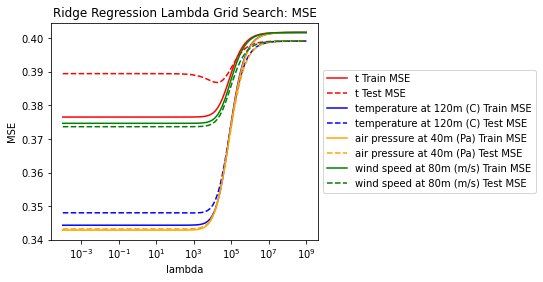

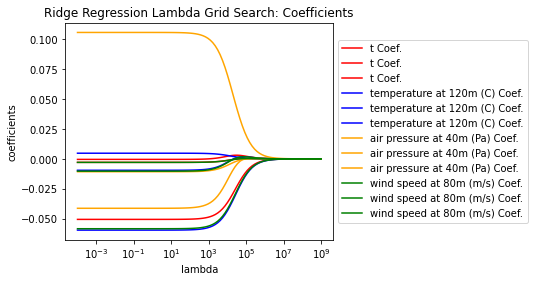

{'lambdas': array([1.00000000e-04, 1.35304777e-04, 1.83073828e-04, 2.47707636e-04,
        3.35160265e-04, 4.53487851e-04, 6.13590727e-04, 8.30217568e-04,
        1.12332403e-03, 1.51991108e-03, 2.05651231e-03, 2.78255940e-03,
        3.76493581e-03, 5.09413801e-03, 6.89261210e-03, 9.32603347e-03,
        1.26185688e-02, 1.70735265e-02, 2.31012970e-02, 3.12571585e-02,
        4.22924287e-02, 5.72236766e-02, 7.74263683e-02, 1.04761575e-01,
        1.41747416e-01, 1.91791026e-01, 2.59502421e-01, 3.51119173e-01,
        4.75081016e-01, 6.42807312e-01, 8.69749003e-01, 1.17681195e+00,
        1.59228279e+00, 2.15443469e+00, 2.91505306e+00, 3.94420606e+00,
        5.33669923e+00, 7.22080902e+00, 9.77009957e+00, 1.32194115e+01,
        1.78864953e+01, 2.42012826e+01, 3.27454916e+01, 4.43062146e+01,
        5.99484250e+01, 8.11130831e+01, 1.09749877e+02, 1.48496826e+02,
        2.00923300e+02, 2.71858824e+02, 3.67837977e+02, 4.97702356e+02,
        6.73415066e+02, 9.11162756e+02, 1.23284674e+0

In [48]:
x_features = ["t", "temperature at 120m (C)", "air pressure at 40m (Pa)", "wind speed at 80m (m/s)"]
plot_mse_coeffs(parsed_model_data, model_type="Ridge", x_features=x_features)

After doing the lambda grid search, we see that lambda (the penalty term) must be less than 10^6 because theta coefficients reach 0 at this value, meaning the regression model can no longer fit the data well.

#### Now developing the algorithm:

<img src="alg-regression-pseudo.png" alt="Algorithm" width="400"/>

In [50]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [51]:
def parse_data(data_df, T, x_features=["t"], meters=40):
    parse_model_data = pd.DataFrame()

    for x_ft in x_features:
        # past time and wind direction goes from t_initial -> t_final - 2T
        parse_model_data[f"{x_ft}1"] = data_df[x_ft][:-2*T]
        parse_model_data["e_t1"] = data_df[f"wind direction at {meters}m (deg)"][:-2*T]

        # present time and wind direction goes from t_initial + T -> t_final - T
        parse_model_data[f"{x_ft}2"] = data_df[x_ft][T:-T]
        parse_model_data["e_t2"] = data_df[f"wind direction at {meters}m (deg)"][T:-T]

        # future time and wind direction goes from t_0 + 2T -> t_final
        parse_model_data[f"{x_ft}3"] = data_df[x_ft][2*T:]
        parse_model_data["e_t3"] = data_df[f"wind direction at {meters}m (deg)"][2*T:]

    return parse_model_data

In [52]:
# regression to be used in the wind forecasting algorithm
def regression(X, y, T, model_type):
    ''' 
    param X : np.array : training X data
    param y : np.array : training y data
    param T : int : yaw set-point update period
    param model_type : str : type of linear regression (Ridge or Lasso)
    param lam : int : alpha coefficient of regression, a.k.a. penalty term
    '''
    # split X,y data into training and testing datasets
    test_size = 0.3 # test data represents 30% of full dataset
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size)

    # standardize training and testing data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.fit_transform(X_val)

    # fit model to training data
    model = Ridge(alpha=10**(-6)).fit(X_train, y_train)

    # calculate rsquared,  coefficient of determination
    R2_score = r2_score(y_val, model.predict(X_val))

    # compute regression train and test errors
    train_mse = (np.mean((y_train - model.predict(X_train))**2))
    val_mse = (np.mean((y_val - model.predict(X_val))**2))
    coeff = (model.coef_[0])
    
    return model, R2_score, train_mse, val_mse, coeff

In [53]:
def algorithm(t, wind_dir, T, R_min, model_type, lam):
    '''
    param t : pd.DataFrame : df with columns corresponding to t1 (t1 = t - 2T), t2 (t2 = t - T), and t3 (t3 = t + T)
    param wind_dir : pd.DataFrame : df with columns corresponding to wind direction at t: 
        t1 (t1 = t - 2T), t2 (t2 = t - T), and t3 (t3 = t + T)
    param T : int : the yaw set-point update period
    param R_min : minimum coefficient of determination value R-squared 
        (statistical measure in a regression model that determines the proportion of variance in the dependent variable 
        that can be explained by the independent variable.)
    param model_type : str : type of linear regression (Ridge or Lasso)
    param lam : int : alpha coefficient of regression, a.k.a. penalty term

    returns prediction mean, prediction standard deviation
    '''
    # count of T intervals in time series
    num_T_intervals = int(t.shape[0]/T)

    # lists for storing results
    pred_approaches = list() # either regression or moving avg.
    model_num = list() # 1 or 2
    model_training_set = list() # X values for training
    model_testing_set = list() # X values for test set
    train_mses = list()
    val_mses = list()
    coeffs = list()
    std_devs = list()
    preds = list()
    pred_r2_scores = list()
    test_mses = list()

    # iterate over all yaw set-point periods (T intervals) in time series
    for i in range(num_T_intervals):
        start_t_index = i*T
        end_t_index = (i+1)*T

        # get interval of t1 and wind direction at t1 (np.array format)
        np_t1_interval = t[["t1", "e_t1"]][start_t_index : end_t_index].fillna(0).to_numpy()
        np_e_t1_interval = wind_dir[["e_t1"]][start_t_index : end_t_index].fillna(0).to_numpy()

        # get interval of t2 and wind direction at t2 (np.array format)
        np_t2_interval = t[["t2", "e_t2"]][start_t_index : end_t_index].fillna(0).to_numpy()
        np_e_t2_interval = wind_dir[["e_t2"]][start_t_index : end_t_index].fillna(0).to_numpy()

        # get interval of t3 and wind direction at t3 (np.array format)
        np_t3_interval = t[["t3", "e_t3"]][start_t_index : end_t_index].fillna(0).to_numpy()
        np_e_t3_interval = t[["e_t3"]][start_t_index : end_t_index].fillna(0).to_numpy()

        ## CONFUSED ABOUT THIS !!! training on previous t interval time and wind direction to predict next ?
        # train model 1 on t1 and wind_dir at t1
        model_1, R_squared_1, train_mse_1, val_mse_1, coeff_1 = regression(np_t1_interval, np_e_t1_interval, T, model_type)

        # train model 2 on t2 and wind_dir at t2
        model_2, R_squared_2, train_mse_2, val_mse_2, coeff_2 = regression(np_t2_interval, np_e_t2_interval, T, model_type)

        # append results to lists
        model_num.extend(["1", "2"])
        model_training_set.extend([np_t1_interval, np_t2_interval])
        train_mses.extend([train_mse_1, train_mse_2])
        val_mses.extend([val_mse_1, val_mse_2])
        coeffs.extend([coeff_1, coeff_2])

        # scale the testing datasets for model 1 and 2
        scaler = StandardScaler()
        np_t2_interval_scaled = scaler.fit_transform(np_t2_interval) # t2 and wind dir at t2 => test dataset for model 1
        np_t3_interval_scaled = scaler.fit_transform(np_t3_interval) # t3 and wind dir at t3 => test dataset for model 2
        model_testing_set.extend([np_t2_interval, np_t3_interval])

        # calculate mean squared error of model 1 predictions at t2 vs true t2 data
        mse_fit = np.mean(np_e_t2_interval - model_1.predict(np_t2_interval_scaled)**2)
        mse_mean = np.mean((np_e_t2_interval - np.mean(np_e_t1_interval))**2)

        # initialize model approach indicator
        model_approach = None
        print("fit MSE", mse_fit)
        print("mean MSE ", mse_mean)
        print("R_1 ", R_squared_1)
        print("R_2 ", R_squared_2)
        
        # if prediction results are valid, calculate predictions
        if (mse_fit < mse_mean) and (R_squared_1 >= R_min) and (R_squared_2 >= R_min):
            # define model approach
            model_approach = "regression"
            
            # predictions from model 1 and 2
            pred_1 = model_1.predict(np_t2_interval_scaled)
            pred_2 = model_2.predict(np_t3_interval_scaled)

            # scale results and true values to calculate mses
            np_e_t2_interval_scaled = scaler.fit_transform(np_e_t2_interval)
            np_e_t3_interval_scaled = scaler.fit_transform(np_e_t3_interval)

            # calculate std and MSE for models 1 and 2
            std_dev_1 = np.std(np_e_t2_interval - pred_1)
            test_mse_1 = np.mean((np_e_t2_interval_scaled - scaler.fit_transform(pred_1))**2)
            prediction_r2_score_1 = r2_score(np_e_t2_interval, pred_1)
            std_dev_2 = np.std(np_e_t3_interval - pred_2)
            test_mse_2 = np.mean((np_e_t3_interval_scaled - scaler.fit_transform(pred_2))**2)
            prediction_r2_score_2 = r2_score(np_e_t3_interval, pred_2)

            # store results
            std_devs.extend([std_dev_1, std_dev_2])
            test_mses.extend([test_mse_1, test_mse_2])
            preds.extend([pred_1, pred_2])
            pred_r2_scores.extend([prediction_r2_score_1, prediction_r2_score_2])
            
            # calculate test mse
            print("Regression prediction model 2 R2 score ", prediction_r2_score_2)
            

        # if not, calculate moving average
        else:
            # define model approach
            model_approach = "moving average"

            # make prediction using moving avg approach
            pred_1 = np.mean(np_e_t2_interval)
            pred_2 = np.mean(np_e_t3_interval)

            # calculate results for models 1 and 2
            std_dev_1 = np.std(np_e_t2_interval)
            test_mse_1 = np.mean((np_e_t2_interval - pred_1)**2)
            moving_avg_r2_1 = r2_score(np_e_t2_interval, np.full(np_e_t2_interval.shape, pred_1))
            std_dev_2 = np.std(np_e_t3_interval)
            test_mse_2 = np.mean((np_e_t3_interval - pred_2)**2)
            moving_avg_r2_2 = r2_score(np_e_t3_interval, np.full(np_e_t2_interval.shape, pred_1))
            
            # store results
            std_devs.extend([std_dev_1, std_dev_2])
            test_mses.extend([test_mse_1, test_mse_2])
            preds.extend([pred_1, pred_2])
            pred_r2_scores.extend([moving_avg_r2_1, moving_avg_r2_2])

        # append results to storing lists
        pred_approaches.extend([model_approach, model_approach]) # either regression or moving avg.
        
        print("---------------")
    
    return pred_approaches, model_num, model_training_set, model_testing_set, train_mses, val_mses, coeffs, pred_r2_scores, std_devs, preds, test_mses

In [54]:
def run_algorithm(data_df, T, model_type="Ridge", lam=10**2):
    '''
    param T : int : the yaw set-point update period
    param R_min : minimum coefficient of determination value R-squared 
        (statistical measure in a regression model that determines the proportion of variance in the dependent variable 
        that can be explained by the independent variable.)
    param model_type : str : type of linear regression (Ridge or Lasso)
    param lam : int : alpha coefficient of regression, a.k.a. penalty term
    '''
    # parse model data to have time index and wind direction columns parsed by intervals t1, t2, t3
    parsed_model_data = parse_data(data_df, T, x_features=["t"])

    # drop NaN values
    t1_df = parsed_model_data[["t1", "e_t1"]].dropna()
    t2_df = parsed_model_data[["t2", "e_t2"]].dropna().reset_index().drop(columns=["index"])
    t3_df = parsed_model_data[["t3", "e_t3"]].dropna().reset_index().drop(columns=["index"])
    min_size = min(t1_df.shape[0], t2_df.shape[0], t3_df.shape[0])
    inputs_df = pd.concat([t1_df, t2_df, t3_df], axis=1)[:min_size]

    # divide t inputs and wind_dir outputs
    t = inputs_df[["t1", "t2", "t3", "e_t1", "e_t2", "e_t3"]]
    wind_dir = inputs_df[["e_t1", "e_t2", "e_t3"]]

    # initial R_min threshold - change this
    R_min = 0.6

    # get prediction results
    print(algorithm(t, wind_dir, T, R_min, model_type, lam))
    pred_approaches, model_num, model_training_set,model_testing_set, train_mses, val_mses,  coeffs, pred_r2_scores, std_devs, preds, test_mses = algorithm(t, wind_dir, T, R_min, model_type, lam)
    results_df = pd.DataFrame({"Model Approach": pred_approaches, "Model": model_num, "Training set": model_training_set, "Train MSE": train_mses, "Validation MSE": val_mses,
                "Test set": model_testing_set, "Coeffs": coeffs, "R squared": pred_r2_scores, "Std. Dev": std_devs, "Prediction": preds, "Test MSE": test_mses,})
    
    return inputs_df, results_df

In [55]:
data_df = pd.read_csv("data/NREL data/all_NREL_india_wind_data_2014.csv")
T = 15*60 
inputs_df, outputs_df = run_algorithm(data_df, T)

fit MSE -36275.82023426327
mean MSE  12933.529109369752
R_1  0.9957696402740238
R_2  0.9952904755944377
Regression prediction model 2 R2 score  0.8879050493561875
---------------
fit MSE -25548.914702986847
mean MSE  6055.128199476667
R_1  0.9728172842866424
R_2  0.9970637372453197
Regression prediction model 2 R2 score  0.338291201234149
---------------
fit MSE -17955.956223068835
mean MSE  12225.502228222225
R_1  0.9997087867427438
R_2  0.9906859387701473
Regression prediction model 2 R2 score  0.9664648725583086
---------------
fit MSE -39552.82287622861
mean MSE  9331.622606887408
R_1  0.9989255621769683
R_2  0.994247768981769
Regression prediction model 2 R2 score  0.6402346761161293
---------------
fit MSE -48248.521309636664
mean MSE  10826.928346692222
R_1  0.9935346989649259
R_2  0.9940541817046061
Regression prediction model 2 R2 score  0.9444528707135472
---------------
fit MSE -27550.160704222726
mean MSE  10535.311140427777
R_1  0.999888252968784
R_2  0.9938658136389044
Re

In [56]:
inputs_df

,t1,e_t1,t2,e_t2,t3,e_t3
0,1388534400,61.15,1.389344e+09,101.10,1.390154e+09,81.33
1,1388535300,56.90,1.389345e+09,105.57,1.390155e+09,83.09
2,1388536200,54.70,1.389346e+09,117.80,1.390156e+09,86.59
3,1388537100,51.25,1.389347e+09,182.20,1.390157e+09,85.45
4,1388538000,48.28,1.389348e+09,223.87,1.390158e+09,76.03
...,...,...,...,...,...,...
31435,1416825900,338.97,1.417636e+09,293.58,1.418446e+09,230.09
31436,1416826800,26.38,1.417637e+09,291.75,1.418447e+09,233.17
31437,1416827700,48.33,1.417638e+09,289.59,1.418448e+09,231.69
31438,1416828600,64.36,1.417639e+09,288.70,1.418449e+09,227.42


In [57]:
outputs_df

,Model Approach,Model,Training set,Train MSE,Validation MSE,Test set,Coeffs,R squared,Std. Dev,Prediction,Test MSE
0,regression,1,"[[1388534400.0, 61.15], [1388535300.0, 56.9], ...",2.680281e-14,30.639019,"[[1389344400.0, 101.1], [1389345300.0, 105.57]...","[2.898973956071183e-08, 101.56090658980504]",0.806030,3.130205,"[[147.5192960809688], [151.85564561038103], [1...",8.101811e-20
1,regression,2,"[[1389344400.0, 101.1], [1389345300.0, 105.57]...",2.799018e-14,10.520552,"[[1390154400.0, 81.33], [1390155300.0, 83.09],...","[1.188278638299402e-08, 105.1358151488303]",0.870047,27.458823,"[[76.52704103891836], [78.9092011908375], [83....",1.240537e-20
2,regression,1,"[[1389344400.0, 101.1], [1389345300.0, 105.57]...",2.735532e-14,5.141043,"[[1390154400.0, 81.33], [1390155300.0, 83.09],...","[5.839051578623008e-09, 104.13364105849354]",0.879809,26.456649,"[[76.43966047007542], [78.79911342956632], [83...",3.053352e-21
3,regression,2,"[[1390154400.0, 81.33], [1390155300.0, 83.09],...",1.421614e-14,139.341323,"[[1390964400.0, 192.78], [1390965300.0, 201.91...","[1.884719881525465e-08, 74.19457804744007]",0.283067,11.254905,"[[119.70613267377882], [127.63358263740417], [...",2.865623e-20
4,regression,1,"[[1390154400.0, 81.33], [1390155300.0, 83.09],...",1.539177e-14,70.572324,"[[1390964400.0, 192.78], [1390965300.0, 201.91...","[3.0074728244681344e-08, 75.96002378731453]",0.275719,9.489459,"[[119.32880269036976], [127.44488480391419], [...",6.961503e-20
...,...,...,...,...,...,...,...,...,...,...,...
63,regression,2,"[[1414454400.0, 277.23], [1414455300.0, 276.21...",2.048214e-14,86.313708,"[[1415264400.0, 324.65000000000003], [14152653...","[2.1428646537286752e-08, 89.1689792995341]",0.636091,3.726752,"[[374.62178639837464], [377.5878230741721], [3...",5.081217e-20
64,regression,1,"[[1414454400.0, 277.23], [1414455300.0, 276.21...",1.930673e-14,3.390458,"[[1415264400.0, 324.65000000000003], [14152653...","[1.9379902876370765e-08, 86.6984335203214]",0.609770,6.197298,"[[372.46524613366296], [375.34910479813357], [...",4.396292e-20
65,regression,2,"[[1415264400.0, 324.65000000000003], [14152653...",2.472100e-14,6.183500,"[[1416074400.0, 169.48], [1416075300.0, 170.34...","[-6.038660639716786e-08, 92.46891922813928]",0.979420,5.013258,"[[156.88199827399544], [157.79129641524216], [...",4.003287e-19
66,regression,1,"[[1415264400.0, 324.65000000000003], [14152653...",2.501015e-14,27.320458,"[[1416074400.0, 169.48], [1416075300.0, 170.34...","[-6.141806219675776e-08, 92.87394436076475]",0.971674,5.418283,"[[154.60866322283073], [155.521944200722], [15...",4.105174e-19


In [171]:
def plot_mses(results_df, ):
    # color code each feature x saleprice regression
    colors = ['red', 'blue', 'orange', 'green', 'grey']
    
    model_1_condition = (results_df.Model == "1")
    model_2_condition = (results_df.Model == "2")

    mses_to_plot = ["Train MSE", "Validation MSE", "Test MSE"]
    line_styles = ["solid", "dashed", "dotted"]

    for i in range(len(mses_to_plot)):
        # plot model 1
        plt.plot(range(34), results_df.loc[model_1_condition][mses_to_plot[i]], label="Model 1 "+mses_to_plot[i], color="red", linestyle=line_styles[i])
        # plot model 2
        plt.plot(range(34), results_df.loc[model_2_condition][mses_to_plot[i]], label="Model 2 "+mses_to_plot[i], color="blue", linestyle=line_styles[i])

    # create MSE plot axes and labels
    plt.title("Ridge Regression MSE")
    plt.xlabel("T interval index")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()

In [172]:
def plot_true_v_pred(outputs_df, t_interval_index=0):

    # filtering by model 1 and 2
    model_1_df = outputs_df.loc[outputs_df.Model == "1"].reset_index()
    model_2_df = outputs_df.loc[outputs_df.Model == "2"].reset_index()

    # model approach (regression or moving avg.)
    model_method = model_1_df.iloc[t_interval_index]["Model Approach"]
    
    # t indices
    t2 = model_1_df.iloc[t_interval_index]["Test set"][:,0]
    t3 = model_2_df.iloc[t_interval_index]["Test set"][:,0]

    # true values
    true_wind_t2 = model_1_df.iloc[t_interval_index]["Test set"][:,1]
    true_wind_t3 = model_2_df.iloc[t_interval_index]["Test set"][:,1]

    # model predictions
    pred_wind_t2 = model_1_df.iloc[t_interval_index].Prediction
    pred_wind_t3 = model_2_df.iloc[t_interval_index].Prediction
    
    # create figure to plot it
    fig = plt.figure(figsize=(8, 6), dpi=80)
    ax = plt.subplot(111)
    # shrink axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0,box.y0,box.width*0.8,box.height])

    # plot values
    ax.plot(t2, true_wind_t2, label="True wind dir at t2", linestyle="solid")
    ax.plot(t2, pred_wind_t2, label="Predicted wind dir at t2 (model 1)", linestyle="dashed")

    ax.plot(t3, true_wind_t3, label="True wind dir at t3", linestyle="solid")
    ax.plot(t3, pred_wind_t3, label="Predicted wind dir at t3 (model 2)", linestyle="dashed")
    
    # setting axes and titles
    ax.set_ylabel("Wind direction (deg)")
    ax.set_xlabel("t index")
    ax.set_title(f"{model_method} model results true v. predicted, run {t_interval_index}")
    
    # moving legend outside of plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

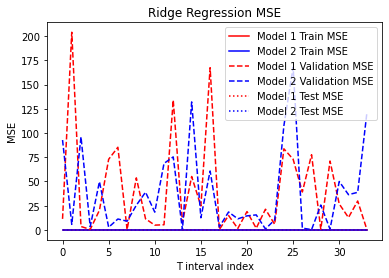

In [173]:
plot_mses(outputs_df)

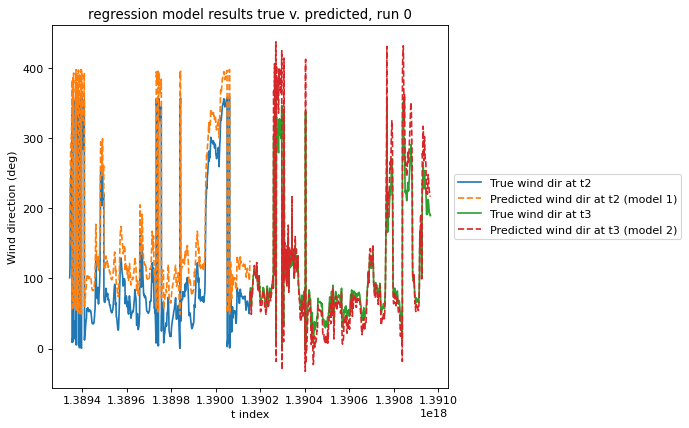

In [169]:
plot_true_v_pred(outputs_df, t_interval_index=0)

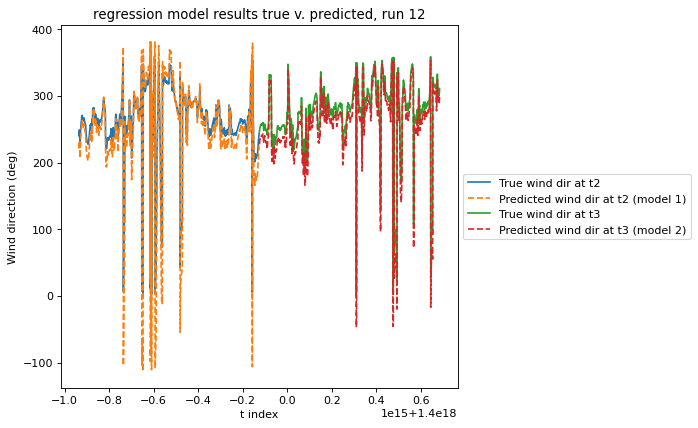

In [170]:
plot_true_v_pred(outputs_df, t_interval_index=12)

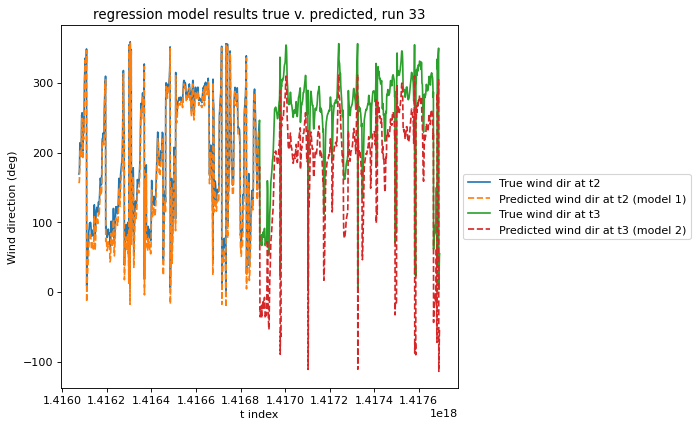

In [174]:
from random import randint, random

random_t = randint(0,36)
plot_true_v_pred(outputs_df, t_interval_index=random_t)